<a href="https://www.kaggle.com/code/mohadesehemamipour/f1-score-91-with-densenet121-model?scriptVersionId=290562995" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2026-01-07 15:37:38.742117: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767800258.989288      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767800259.061896      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767800259.658600      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767800259.659190      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767800259.659194      17 computation_placer.cc:177] computation placer alr

# 1. Initial settings and routes

In [2]:
BASE_DIR = "/kaggle/input/human-bones-fractured-vs-non-fractured-dataset/human-bones-fractured-vs-non-fractured_split_dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [3]:
IMG_SIZE = (224, 224) 

# Increase batch size for gradient stability
BATCH_SIZE = 32 


# 2. Data generators with dedicated DenseNet pre-processing

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=1, class_mode='binary', shuffle=False
)


Found 294 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


# 3. Calculating class weights (to solve the problem of data imbalance)

In [5]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(weights))

# 4. Improved DenseNet121 model definition

In [6]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x) # Added for more stability
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Prevent Overfitting
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freezing the initial layers for the first stage of training
for layer in base_model.layers:
    layer.trainable = False

2026-01-07 15:37:57.934884: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# 5. Setting up Callbacks

In [7]:
checkpoint = ModelCheckpoint("/kaggle/working/best_bone_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Reducing the learning rate when the model is stuck
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

# 6. The first stage of training (Transfer Learning)

In [8]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

print("Starting Initial Training...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop, lr_reducer]
)


Starting Initial Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3708 - loss: 0.9558

10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.3767 - loss: 0.9461 - val_accuracy: 0.4355 - val_loss: 0.8306 - learning_rate: 1.0000e-04
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5975 - loss: 0.6388

10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5970 - loss: 0.6392 - val_accuracy: 0.7258 - val_loss: 0.5941 - learning_rate: 1.0000e-04
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6135 - loss: 0.5853

10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.6189 - loss: 0.5829 - val_accuracy: 0.7742 - val_loss: 0.4998 - learning_rate: 1.0000e-04
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7175 - loss: 0.4793

10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.7181 - loss: 0.4797 - val_accuracy: 0.7903 - val_loss: 0.4563 - learning_rate: 1.0000e-04
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7974 - loss: 0.4158 - val_accuracy: 0.7903 - val_loss: 0.4343 - learning_rate: 1.0000e-04
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7872 - loss: 0.4264 - val_accuracy: 0.7903 - val_loss: 0.4181 - learning_rate: 1.0000e-04
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7867 - loss: 0.4028 - val_accuracy: 0.7742 - val_loss: 0.4124 - learning_rate: 1.0000e-04
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.7988 - loss: 0.3759 - val_accuracy: 0.7903 - val_loss: 0.4063 - learning_rate: 1.0000e-04
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.7632 - loss: 0.4149 - val_accuracy: 0.7742 - val_loss: 0.3915 - learning_rate: 1.0000e-04
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.8456 - loss: 0.3322 - 

10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8418 - loss: 0.2693 - val_accuracy: 0.8226 - val_loss: 0.3769 - learning_rate: 1.0000e-04
Epoch 13/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8221 - loss: 0.3637 - val_accuracy: 0.8226 - val_loss: 0.3774 - learning_rate: 1.0000e-04
Epoch 14/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8657 - loss: 0.3350

10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.8659 - loss: 0.3318 - val_accuracy: 0.8387 - val_loss: 0.3707 - learning_rate: 1.0000e-04
Epoch 15/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.8718 - loss: 0.2958 - val_accuracy: 0.8226 - val_loss: 0.3577 - learning_rate: 1.0000e-04


# 7. Second stage of training (Fine-tuning)

In [9]:
# Open the last 50 layers to learn specific X-Ray patterns
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

print("Starting Fine-tuning...")
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop, lr_reducer]
)

Starting Fine-tuning...
Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.8706 - loss: 0.2968 - val_accuracy: 0.8226 - val_loss: 0.3546 - learning_rate: 1.0000e-05
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8782 - loss: 0.3085 - val_accuracy: 0.8226 - val_loss: 0.3514 - learning_rate: 1.0000e-05
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8957 - loss: 0.2550 - val_accuracy: 0.8226 - val_loss: 0.3491 - learning_rate: 1.0000e-05
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8771 - loss: 0.2612 - val_accuracy: 0.8387 - val_loss: 0.3482 - learning_rate: 1.0000e-05
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8595 - loss: 0.2986 - val_accuracy: 0.8387 - val_loss: 0.3470 - learning_rate: 1.0000e-05
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8514 - loss: 0.2885 - val_accuracy: 0.8387 - val_loss: 0.3463 - learning_rate: 1.0000e-05
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - 

10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8831 - loss: 0.2857 - val_accuracy: 0.8710 - val_loss: 0.3432 - learning_rate: 1.0000e-05
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.9044 - loss: 0.2248 - val_accuracy: 0.8710 - val_loss: 0.3420 - learning_rate: 1.0000e-05
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.9013 - loss: 0.2437 - val_accuracy: 0.8548 - val_loss: 0.3409 - learning_rate: 1.0000e-05
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8126 - loss: 0.3371 - val_accuracy: 0.8548 - val_loss: 0.3398 - learning_rate: 1.0000e-05
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8515 - loss: 0.2870 - val_accuracy: 0.8548 - val_loss: 0.3380 - learning_rate: 1.0000e-05
Epoch 13/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8761 - loss: 0.2369 - val_accuracy: 0.8226 - val_loss: 0.3377 - learning_rate: 1.0000e-05
Epoch 14/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.8559 - loss: 0.284

# 8. Final Evaluation and Report

In [10]:
# Evaluation

print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = test_generator.classes

print(f"Final Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))



--- Final Evaluation on Test Set ---
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step
Final Accuracy: 0.8906

Classification Report:
                precision    recall  f1-score   support

    Fractured       0.78      0.90      0.84        20
Non-Fractured       0.95      0.89      0.92        44

     accuracy                           0.89        64
    macro avg       0.87      0.89      0.88        64
 weighted avg       0.90      0.89      0.89        64



#  Accuracy & Loss Chart & Confusion Matrix

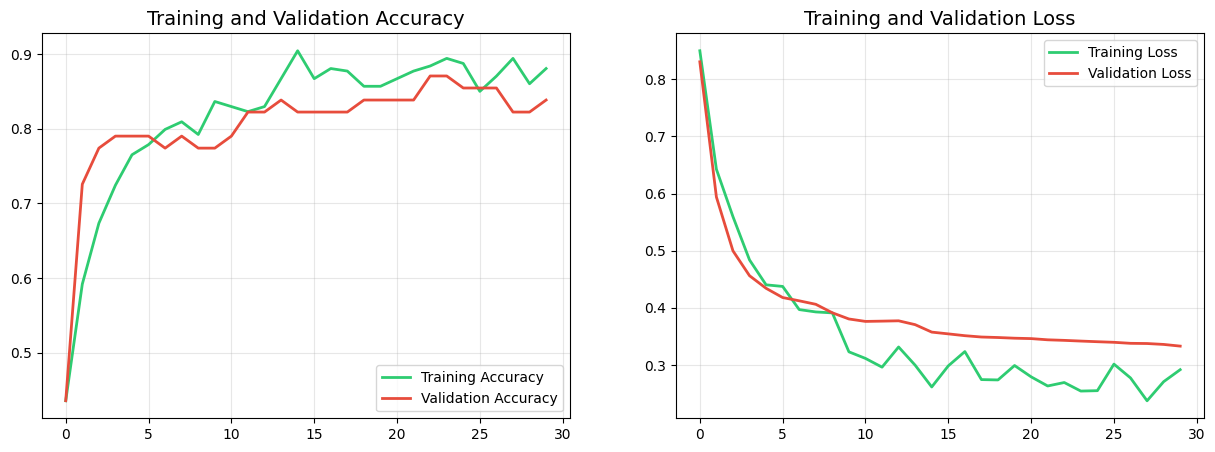

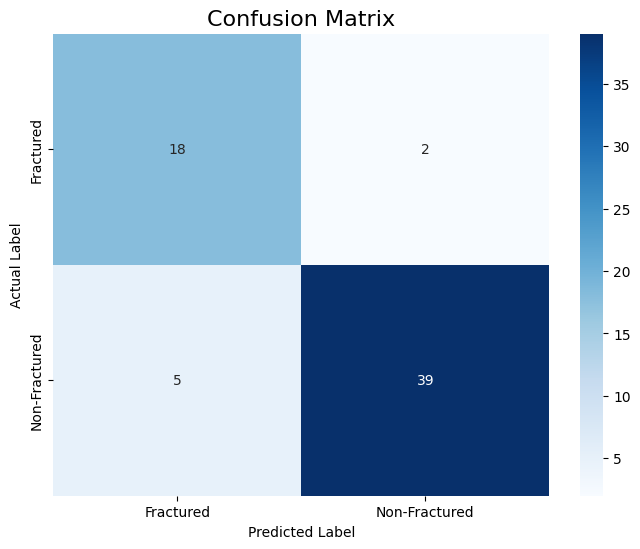

/tmp/ipykernel_17/1586443391.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = classes[int(prediction > 0.5)]
/tmp/ipykernel_17/1586443391.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = classes[int(label)]


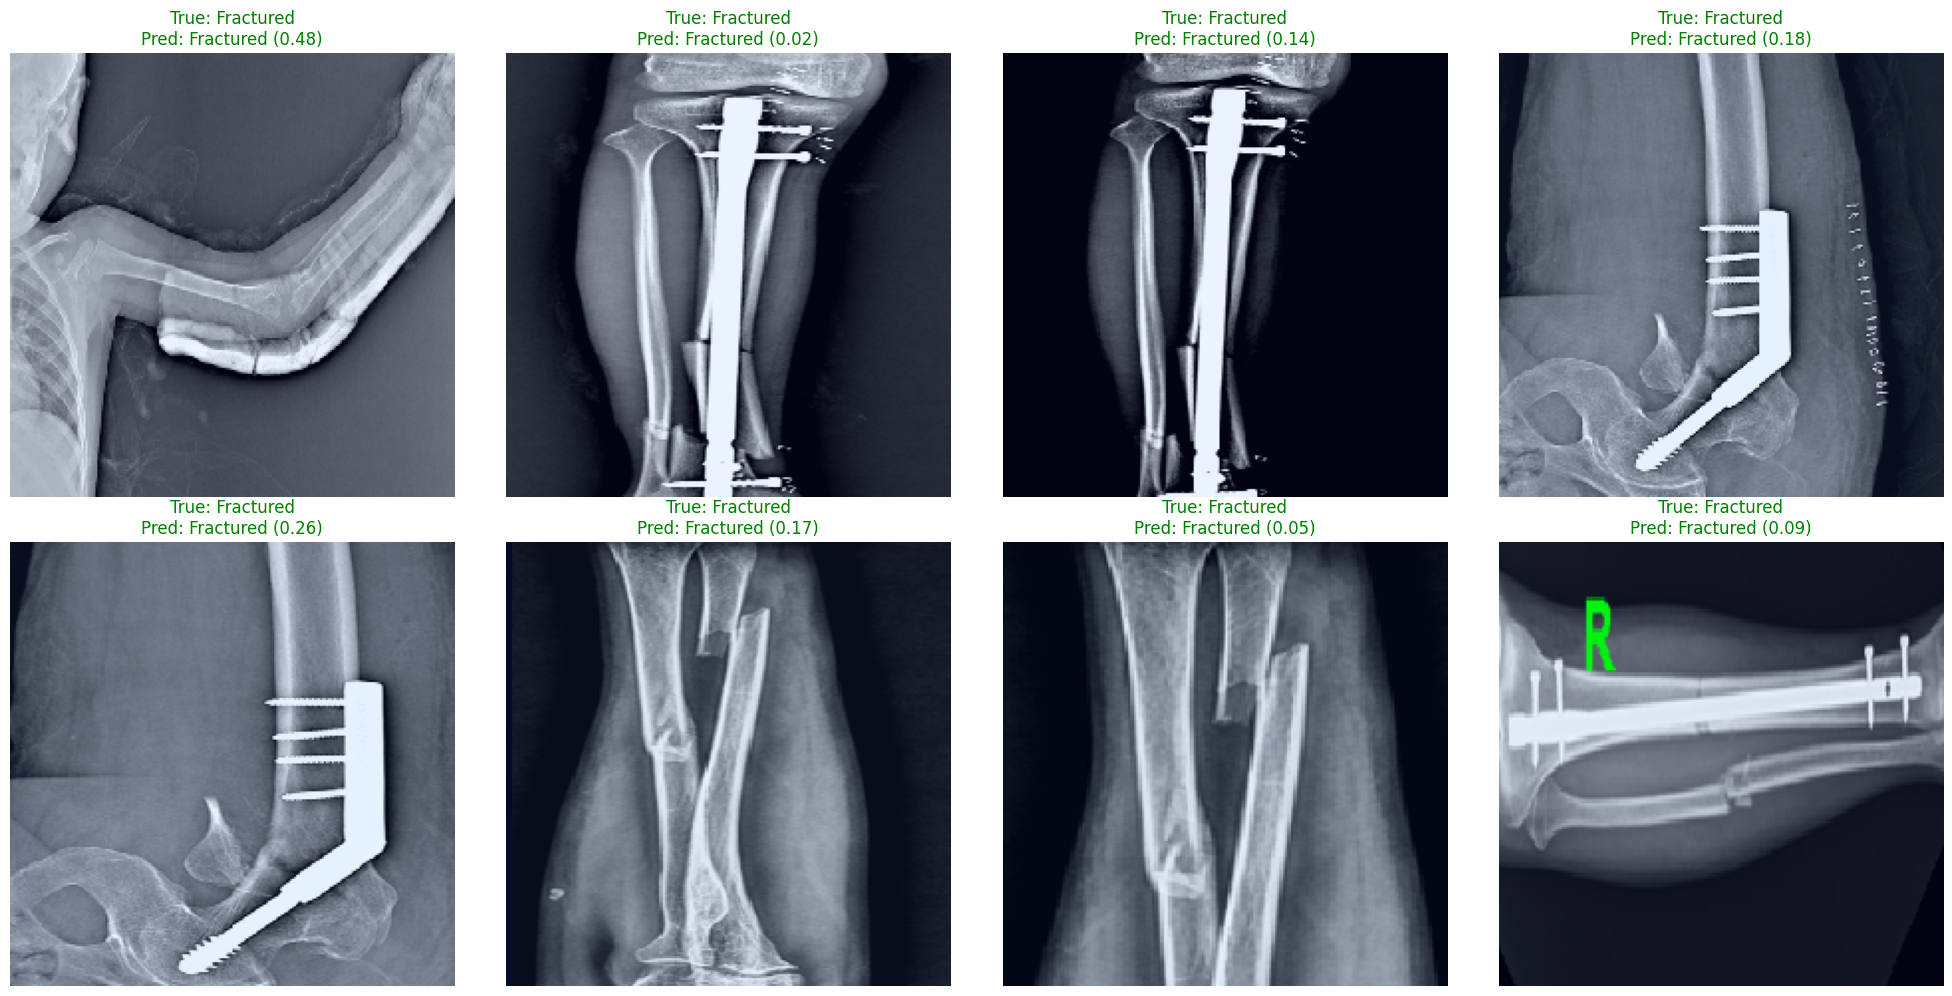

In [11]:
import seaborn as sns

# Accuracy and Loss Trend Chart
def plot_history(history, history_finetune):
    acc = history.history['accuracy'] + history_finetune.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
    loss = history.history['loss'] + history_finetune.history['loss']
    val_loss = history.history['val_loss'] + history_finetune.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(15, 5))
    
    # Accuracy chart
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='#2ecc71', lw=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#e74c3c', lw=2)
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # Loss Chart
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='#2ecc71', lw=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='#e74c3c', lw=2)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    plt.show()

# Drawing a nice-looking confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Display test images along with model predictions
def visualize_predictions(model, test_generator, num_samples=8):
    plt.figure(figsize=(20, 10))
    # Reset the generator to ensure correct sequence
    test_generator.reset()
    
    # Taking a bunch of pictures
    images, labels = next(test_generator) # Since batch_size=1, we use it in the loop
    
    classes = list(test_generator.class_indices.keys())
    
    for i in range(num_samples):
        img, label = test_generator[i]
        prediction = model.predict(img, verbose=0)
        pred_label = classes[int(prediction > 0.5)]
        true_label = classes[int(label)]
        
        plt.subplot(2, 4, i + 1)
        # Image display (must be exited from preprocessing mode for colors to be correct)
        # If you used preprocess_input, normalize the image for display.
        display_img = (img[0] - img[0].min()) / (img[0].max() - img[0].min())
        plt.imshow(display_img)
        
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label} ({prediction[0][0]:.2f})", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Implementing visualization functions
plot_history(history, history_finetune)
plot_confusion_matrix(y_true, y_pred, list(test_generator.class_indices.keys()))
visualize_predictions(model, test_generator)


# 9. Save the final model

In [12]:
# Save the final model
model.save("/kaggle/working/bone_fracture_final_model_with_callbacks.h5")
print("Final model saved successfully!")

Final model saved successfully!


# Save the final model in the new Keras format (recommended in 2026)

In [13]:
# Save the final model in the new Keras format (recommended in 2026)
model.save("/kaggle/working/bone_fracture_model_v2.keras")
print("Final model saved successfully!")

Final model saved successfully!
